#

# Sistem Inferensi Fuzzy dalam Klasifikasi Kualitas Air Minum
Anggota:
- Ariq Naufal Fadhlurrahman - 103012480010
- M. Agung Isra Narwin - 103012480038

In [1]:
# Import dependencies
import numpy as np 
import skfuzzy as fuzz 
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing

In [18]:
# Load dataset
df = pd.read_csv('water_potability.csv')

# Menghapus kolom yang kosong
df_filtered = df[["ph", "Turbidity", "Potability"]].dropna()

# Ambil fitur yang digunakan untuk fuzzy system
features = ['ph', 'Turbidity']
target = 'Potability'


scaler = MinMaxScaler()
df_filtered[["ph", "Turbidity"]] = scaler.fit_transform(df_filtered[["ph", "Turbidity"]])
df_sample = df_filtered.sample(n=400, random_state=42)

df_filtered.head()

,ph,Turbidity,Potability
1,0.265434,0.604719,0
2,0.578509,0.318338,0
3,0.594055,0.630115,0
4,0.649445,0.520358,0
5,0.398863,0.219973,0


## Rentang nilai

In [5]:
ph_area = np.arange(0, 1.01, 0.01) # pH Air
turbidity_area = np.arange(0, 1.01, 0.01) # Tingkat kekeruhan
potability_area = np.arange(0, 1.01, 0.01) # Potabilitas air

## Metode Mamdani

In [7]:
# Fuzzy input
ph = ctrl.Antecedent(ph_area, 'pH')
turbidity = ctrl.Antecedent(turbidity_area, 'turbidity')

# Fuzzy output
potability = ctrl.Consequent(potability_area, 'potability')

# Membership functions untuk pH
ph['low'] = fuzz.sigmf(ph.universe, 0.3, -10)
ph['normal'] = fuzz.trimf(ph.universe, [0.3, 0.5, 0.7])
ph['high'] = fuzz.sigmf(ph.universe, 0.7, 10)

# Membership functions untuk Tingkat kekeruhan
turbidity['clear'] = fuzz.sigmf(turbidity.universe, 0.3, -10)
turbidity['medium'] = fuzz.trimf(turbidity.universe, [0.3, 0.5, 0.7])
turbidity['murky'] = fuzz.sigmf(turbidity.universe, 0.7, 10)

# Membership functions untuk Potabilitas air
potability['not_potable'] = fuzz.sigmf(potability.universe, 0.5, -10)
potability['potable'] = fuzz.sigmf(potability.universe, 0.5, 10)

# Rules
rule1 = ctrl.Rule(ph['low'] & turbidity['murky'], potability['not_potable'])
rule2 = ctrl.Rule(ph['normal'] & turbidity['clear'], potability['potable'])
rule3 = ctrl.Rule(ph['high'] & turbidity['murky'], potability['not_potable'])
rule4 = ctrl.Rule(ph['normal'] & turbidity['medium'], potability['potable'])
rule5 = ctrl.Rule(ph['low'] | turbidity['murky'], potability['not_potable'])

potability_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
potability_sim = ctrl.ControlSystemSimulation(potability_ctrl)

def mamdani_inference(ph, turbidity):
    potability_sim.input['pH'] = ph
    potability_sim.input['turbidity'] = turbidity

    potability_sim.compute()
    return potability_sim.output['potability']

## Graf Membership Function

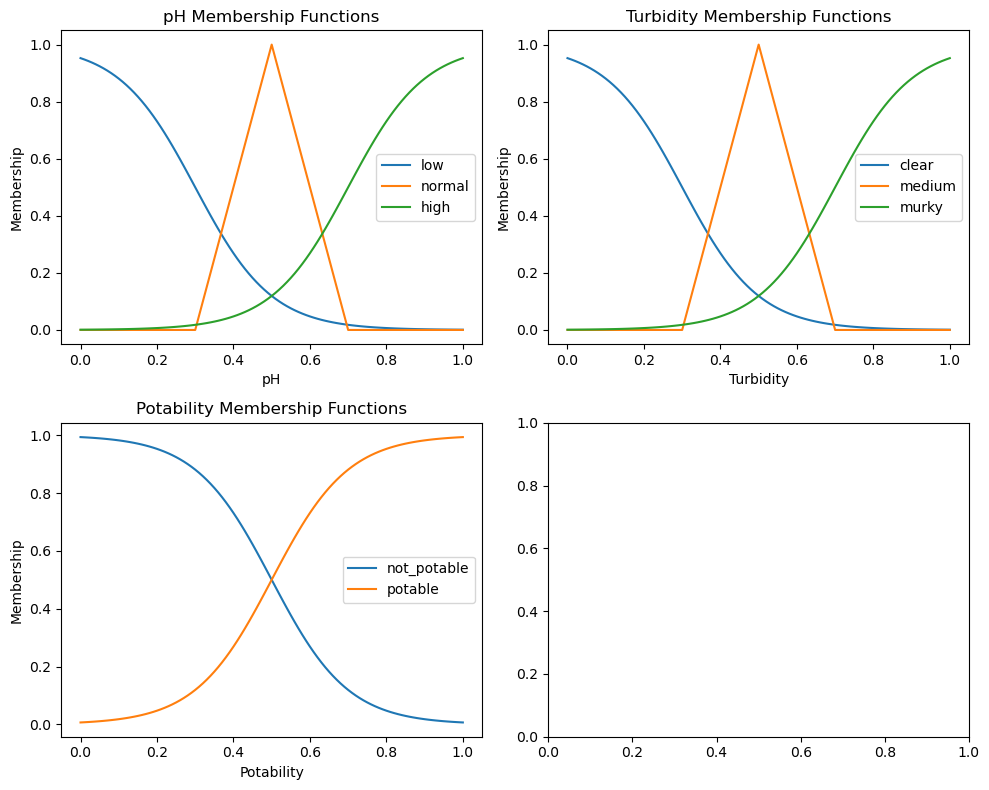

In [8]:
# Plotting the membership functions to grid
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# pH
for term in ph.terms:
	ax[0, 0].plot(ph.universe, ph[term].mf, label=term)
ax[0, 0].set_title('pH Membership Functions')
ax[0, 0].set_xlabel('pH')
ax[0, 0].set_ylabel('Membership')
ax[0, 0].legend()

# Turbidity
for term in turbidity.terms:
	ax[0, 1].plot(turbidity.universe, turbidity[term].mf, label=term)
ax[0, 1].set_title('Turbidity Membership Functions')
ax[0, 1].set_xlabel('Turbidity')
ax[0, 1].set_ylabel('Membership')
ax[0, 1].legend()

# Potability
for term in potability.terms:
	ax[1, 0].plot(potability.universe, potability[term].mf, label=term)
ax[1, 0].set_title('Potability Membership Functions')
ax[1, 0].set_xlabel('Potability')
ax[1, 0].set_ylabel('Membership')
ax[1, 0].legend()

plt.tight_layout()
plt.show()

## Metode Sugeno

In [13]:
def sugeno(ph_val, turb_val):
    ph_low = fuzz.interp_membership(ph_area, fuzz.sigmf(ph_area, 0.3, -10), ph_val)
    ph_norm = fuzz.interp_membership(ph_area, fuzz.trimf(ph_area, [0.3, 0.5, 0.7]), ph_val)
    ph_high = fuzz.interp_membership(ph_area, fuzz.sigmf(ph_area, 0.7, 10), ph_val)

    turb_low = fuzz.interp_membership(turbidity_area, fuzz.sigmf(turbidity_area, 0.3, -10), turb_val)
    turb_med = fuzz.interp_membership(turbidity_area, fuzz.trimf(turbidity_area, [0.3, 0.5, 0.7]), turb_val)
    turb_high = fuzz.interp_membership(turbidity_area, fuzz.sigmf(turbidity_area, 0.7, 10), turb_val)

    rules = [
        (min(ph_low, turb_high), 0), # Rule 1: low ph & murky => not potable
        (min(ph_norm, turb_low), 1),  # Rule 2: normal ph & clear => potable
        (min(ph_high, turb_high), 0),  # Rule 3: high ph & murky => not potable
        (min(ph_norm, turb_med), 1),  # Rule 4: normal ph & medium => potable
        (max(ph_low, turb_high), 0)  # Rule 5: low ph or murky => not potable
    ]

    # Weighted average (Sugeno)
    numerator = sum([strength * output for strength, output in rules])
    denominator = sum([strength for strength, _ in rules])

    return 0 if denominator == 0 else numerator / denominator

## Perbandingan kedua metode

In [19]:
y_true = df_sample[target].values
y_pred_mamdani = []
y_pred_sugeno = []

for _, row in df_sample.iterrows():
    ph_val, turb_val = row[features]

    potability_mamdani = mamdani_inference(ph_val, turb_val)
    potability_sugeno = sugeno(ph_val, turb_val)

    y_pred_mamdani.append(1 if potability_mamdani > 0.5 else 0)
    y_pred_sugeno.append(1 if potability_sugeno > 0.5 else 0)

accuracy_mamdani = accuracy_score(y_true, y_pred_mamdani)
accuracy_sugeno = accuracy_score(y_true, y_pred_sugeno)
f1_mamdani = f1_score(y_true, y_pred_mamdani,)
f1_sugeno = f1_score(y_true, y_pred_sugeno,)
recall_mamdani = recall_score(y_true, y_pred_mamdani,)
recall_sugeno = recall_score(y_true, y_pred_sugeno,)
precision_mamdani = precision_score(y_true, y_pred_mamdani,)
precision_sugeno = precision_score(y_true, y_pred_sugeno,)

print(f"Accuracy Mamdani: {accuracy_mamdani:.2f}, Accuracy Sugeno: {accuracy_sugeno:.2f}")
print(f"Recall Mamdani: {recall_mamdani:.2f}, Recall Sugeno: {recall_sugeno:.2f}")
print(f"Precision Mamdani: {precision_mamdani:.2f}, Precision Sugeno: {precision_sugeno:.2f}")
print(f"F1 Score Mamdani: {f1_mamdani:.2f}, F1 Score Sugeno: {f1_sugeno:.2f}")



Accuracy Mamdani: 0.46, Accuracy Sugeno: 0.49
Recall Mamdani: 0.70, Recall Sugeno: 0.66
Precision Mamdani: 0.40, Precision Sugeno: 0.42
F1 Score Mamdani: 0.51, F1 Score Sugeno: 0.51
